In [1]:
import numpy as np
from pylab import *

from synchrotron_simulator_gpu_Dataset_4D import SimulationRunner, SynchrotronSimulator
from automate_dataset_collection import SimulationDataset
import time

In [2]:
# theta_kick = (k_nominal * delta * L_quad)  # Small angular kick

### Configurations

In [3]:
np.rad2deg(1.8)

103.13240312354819

In [4]:
np.deg2rad(30)

0.5235987755982988

In [5]:
# Define base simulation configurations with embedded quadrupole errors


base_configurations = [
    {
        'config_name': 'Configuration 1',
        'design_radius': 20.0,    # meters
        'n_FODO': 8,
        'f': 15,                 # meters
        'L_quad': 0.4,             # meters
        # 'L_straight': 1,         # meters
        # 'total_dipole_bending_angle': (2 * np.pi),#(3 / 3) * np.pi,

        'quad_errors': [
            # {
            #     'FODO_index': 0,
            #     'quad_type': 'defocusing',
            #     'delta': 2,
            #     'plane': 'vertical'  # 'horizontal' or 'vertical'
            # },
            {
                'FODO_index': 1,
                'quad_type': 'defocusing',
                'delta': 1e-6,
                'plane': 'vertical'  # 'horizontal' or 'vertical'
            },
            {
                'FODO_index': 2,
                'quad_type': 'defocusing',
                'delta': 1e-2,
                'plane': 'vertical'  # 'horizontal' or 'vertical'
            },
            {
                'FODO_index': 3,
                'quad_type': 'defocusing',
                'delta': 1e-7,
                'plane': 'vertical'  # 'horizontal' or 'vertical'
            },
            {
                'FODO_index': 4,
                'quad_type': 'defocusing',
                'delta': 1e-7,
                'plane': 'vertical'  # 'horizontal' or 'vertical'
            },
            {
                'FODO_index': 5,
                'quad_type': 'defocusing',
                'delta': 1e-7,
                'plane': 'vertical'  # 'horizontal' or 'vertical'
            },
            # {
            #     'FODO_index': 6,
            #     'quad_type': 'defocusing',
            #     'delta': 1e-7,
            #     'plane': 'vertical'  # 'horizontal' or 'vertical'
            # },
            {
                'FODO_index': 7,
                'quad_type': 'defocusing',
                'delta': 1e-7,
                'plane': 'vertical'  # 'horizontal' or 'vertical'
            },
        ],
        
        "dipole_tilt_errors": None,
        
        'quad_tilt_errors': [
            {
                'FODO_index': 1,
                'quad_type': 'defocusing',
                'tilt_angle': -0.349066
            },
            {
                'FODO_index': 3,
                'quad_type': 'defocusing',
                'tilt_angle': 0.349066
            },
            {
                'FODO_index': 6,
                'quad_type': 'defocusing',
                'tilt_angle': 0.5
            },   
        ],
        
        # "quad_tilt_errors": None,
        
    },
]

common_parameters = {
    'p': 5.344286e-19,                # Momentum in kg m/s (p_GeV_c=0.7)
    'G': 1.0,                         # Tesla/meter
    'q': 1.602e-19,                   # Proton charge in Coulombs
    'n_turns': 5,                   # Number of revolutions to simulate
    'num_particles': 500000,             # Number of particles to simulate
    'window_size': 10,                # Average window size for moving averages
    'use_thin_lens': True,
    # Uniform - Initial conditions ranges as tuples
    'x0_mean_std': (0.0, 0.05),      # meters
    'xp0_mean_std': (0.0, 0.00),  # radians
    'y0_mean_std': (0.0, 0.05),      # meters
    'yp0_mean_std': (0.0, 0.00),  # radians
    'particles_sampling_method': 'from_twiss_params', # from_twiss_params | circle_with_radius | normal
    'sampling_circle_radius': 0.01, #meters,
    # Acceptable ranges config params
    'mag_field_range': [0.1, 20.0],           # Tesla
    'dipole_length_range': [0.1, 14.0],       # meters
    'horizontal_tune_range': [0.01, 0.8],     # Tune
    'vertical_tune_range': [0.01, 0.8],        # Tune
    'total_dipole_bending_angle_range': (1.5 * np.pi, 2 * np.pi),
    # Use cuda GPU kernels to accelerate simulation
    'use_gpu': True,
    # Log
    'verbose': True,
    # BPM readings log criterion
    # record_full_revolution. By default records for cell_idx=0
    # 'record_full_revolution': False,
    # enable storing BPM readings for all BPMs after each full revolution relative to each BPM
    # requires to set record_full_revolution to `True`
    # 'record_full_revolution_per_bpm': False,

    # Parameters for generate_data
    'target_data': 'quad_misalign_deltas',  # ['quad_misalign_deltas', 'quad_tilt_angles', 'dipole_tilt_angles']
    'reject_multiple_error_types': False,
    'start_rev': 1500,
    'end_rev': 2000, # should be same as <= n_turns
    'apply_avg': True,
    'fodo_cell_indices': [0, 1, 2, 3, 4, 5, 6, 7],  # Indices of BPMs to consider
    'planes': ['x', 'y'],
    'random_criterion': 'normal', # uniform | normal
    # if 'random_criterion' is 'uniform'
        # then >> _range is (low, high)
    # if 'random_criterion' is 'normal'
        # then >> _range is (mean, std)
    'delta_range': (0, 5e-5),
    'quad_tilt_angle_range': (-0.10, 0.10), # 100 mrad (1e-3 = 1 mrad)
    'dipole_tilt_angle_range': (0, 0.05), # 50 mrad
    'com_delta_range': (-50e-6, 50e-6),
}


In [6]:
base_configurations

[{'config_name': 'Configuration 1',
  'design_radius': 20.0,
  'n_FODO': 8,
  'f': 15,
  'L_quad': 0.4,
  'quad_errors': [{'FODO_index': 1,
    'quad_type': 'defocusing',
    'delta': 1e-06,
    'plane': 'vertical'},
   {'FODO_index': 2,
    'quad_type': 'defocusing',
    'delta': 0.01,
    'plane': 'vertical'},
   {'FODO_index': 3,
    'quad_type': 'defocusing',
    'delta': 1e-07,
    'plane': 'vertical'},
   {'FODO_index': 4,
    'quad_type': 'defocusing',
    'delta': 1e-07,
    'plane': 'vertical'},
   {'FODO_index': 5,
    'quad_type': 'defocusing',
    'delta': 1e-07,
    'plane': 'vertical'},
   {'FODO_index': 7,
    'quad_type': 'defocusing',
    'delta': 1e-07,
    'plane': 'vertical'}],
  'dipole_tilt_errors': None,
  'quad_tilt_errors': [{'FODO_index': 1,
    'quad_type': 'defocusing',
    'tilt_angle': -0.349066},
   {'FODO_index': 3, 'quad_type': 'defocusing', 'tilt_angle': 0.349066},
   {'FODO_index': 6, 'quad_type': 'defocusing', 'tilt_angle': 0.5}]}]

In [7]:
sampling_func = None
if common_parameters['random_criterion'] == 'uniform':
    sampling_func = np.random.uniform
elif common_parameters['random_criterion'] == 'normal':
    sampling_func = np.random.normal


# Target prediction (Misalignment)
quadrupole_errors_target_values = {}

base_config = base_configurations[0]

if base_config['quad_errors']:
    fodo_indices_with_error = [err['FODO_index'] for err in base_config['quad_errors']]
else:
    fodo_indices_with_error = []

if base_config['quad_tilt_errors']:
    fodo_indices_with_quad_tilt_error = [err['FODO_index'] for err in base_config['quad_tilt_errors']]
else:
    fodo_indices_with_quad_tilt_error = []

mean_or_min_delta, std_or_max_delta = common_parameters['delta_range']
mean_or_min_quad_tilt_error, std_or_max_quad_tilt_error = common_parameters['quad_tilt_angle_range']

# Apply quad misalignment errors
if base_config['quad_errors']:
    for qe_ix, qe in enumerate(base_config['quad_errors']):
        if base_config['quad_errors'][qe_ix]['FODO_index'] in fodo_indices_with_error:
            quadrupole_error_delta = sampling_func(mean_or_min_delta, std_or_max_delta)
            quadrupole_errors_target_values[qe_ix] = quadrupole_error_delta
            base_config['quad_errors'][qe_ix]['delta'] = quadrupole_error_delta
            print("_run_evaluation()/ ", qe_ix, qe)
        else:
            base_config['quad_errors'][qe_ix]['delta'] = 0.0

# Apply quad_tilt_errors
if base_config['quad_tilt_errors']:
    for qe_ix, qe in enumerate(base_config['quad_tilt_errors']):
        if base_config['quad_tilt_errors'][qe_ix]['FODO_index'] in fodo_indices_with_quad_tilt_error:
            quadrupole_tilt_error_delta = sampling_func(mean_or_min_quad_tilt_error, std_or_max_quad_tilt_error)
            print("quadrupole_tilt_error_delta: ", quadrupole_tilt_error_delta)
            
            # TODO(aribra): # Target prediction (Quadrupole Tilt)
            # quadrupole_errors_target_values[qe_ix] = quadrupole_tilt_error_delta
            
            base_config['quad_tilt_errors'][qe_ix]['tilt_angle'] = quadrupole_tilt_error_delta
            print("_run_evaluation()/ ", qe_ix, qe)
        else:
            base_config['quad_tilt_errors'][qe_ix]['tilt_angle'] = 0.0

base_configurations = [base_config]

_run_evaluation()/  0 {'FODO_index': 1, 'quad_type': 'defocusing', 'delta': 4.212955792694383e-05, 'plane': 'vertical'}
_run_evaluation()/  1 {'FODO_index': 2, 'quad_type': 'defocusing', 'delta': 4.5195851106439866e-05, 'plane': 'vertical'}
_run_evaluation()/  2 {'FODO_index': 3, 'quad_type': 'defocusing', 'delta': 4.478180045628106e-05, 'plane': 'vertical'}
_run_evaluation()/  3 {'FODO_index': 4, 'quad_type': 'defocusing', 'delta': -6.1240076842065546e-06, 'plane': 'vertical'}
_run_evaluation()/  4 {'FODO_index': 5, 'quad_type': 'defocusing', 'delta': 2.3839119028078646e-05, 'plane': 'vertical'}
_run_evaluation()/  5 {'FODO_index': 7, 'quad_type': 'defocusing', 'delta': 6.313087532467662e-05, 'plane': 'vertical'}
quadrupole_tilt_error_delta:  0.06197786475591874
_run_evaluation()/  0 {'FODO_index': 1, 'quad_type': 'defocusing', 'tilt_angle': 0.06197786475591874}
quadrupole_tilt_error_delta:  -0.01358292175338624
_run_evaluation()/  1 {'FODO_index': 3, 'quad_type': 'defocusing', 'tilt_

In [8]:
fodo_indices_with_quad_tilt_error

[1, 3, 6]

In [9]:
360 + 90

450

In [10]:
rad2deg(np.pi / 2 * 5)

450.0

In [11]:
# Call the classmethod to find feasible lattices
feasible_lattices = SynchrotronSimulator.find_feasible_lattices(
    base_configurations=base_configurations,
    common_parameters=common_parameters,
    
)

# Check the results
def print_all_feasible_configs(feasible_lattices):
    if feasible_lattices:
        print(f"Found {len(feasible_lattices)} feasible lattice configurations.")
        for idx, config in enumerate(feasible_lattices):
            print(f"\nConfiguration {idx + 1}:")
            for key, value in config.items():
                if isinstance(value, float):
                    print(f"{key}: {value:.4f}")
                else:
                    print(f"{key}: {value}")
    else:
        print("No feasible lattice configurations found.")

check_config =  {'design_radius': 20.0, 'L_quad': 0.4, 'n_FODO': 8, 'L_straight': 3.9269908169872423, 'L_dipole': 5.890486225480862, 'n_Dipoles': 16, 'L_drift': 0.7817477042468106, 'G': 1.0, 'p': 5.344286e-19, 'q': 1.602e-19, 'total_dipole_bending_angle': 4.71238898038469}
build_lattice() completed. Total elements per rev = 64
one turn matrix:
 [[-0.71327933  4.44129232  0.          0.        ]
 [-0.02508091 -1.24580699  0.          0.        ]
 [ 0.          0.         -0.13161168  9.32385644]
 [ 0.          0.         -0.12117472  0.98635379]]
compute_tune_4x4()/ evals =  [-0.97954316+0.2012342j  -0.97954316-0.2012342j   0.42737106+0.90407631j
  0.42737106-0.90407631j]
compute_tune_4x4()/ angles =  [0.17971989927789359, 0.4677523855413338, 0.5322476144586662, 0.8202801007221064]
compute_tune_4x4()/  0.17971989927789359 0.4677523855413338
compute_tunes()/ 0.17971989927789359 0.4677523855413338
build_lattice() completed. Total elements per rev = 64
one turn matrix:
 [[-0.71327933  4.44

In [12]:
len(feasible_lattices)

8

In [13]:
np.rad2deg(4.71238898038469)

270.0

In [14]:
lattice_design = feasible_lattices[0]
lattice_design, 1 / lattice_design['f']

({'design_radius': 20.0,
  'L_quad': 0.4,
  'n_FODO': 8,
  'L_straight': 3.9269908169872423,
  'L_dipole': 5.890486225480862,
  'n_Dipoles': 16,
  'L_drift': 0.7817477042468106,
  'Qx': 0.17971989927789359,
  'Qy': 0.4677523855413338,
  'B': 0.16680043695380775,
  'B_rho': 3.336008739076155,
  'f': 3.336008739076155,
  'G': 1.0,
  'p': 5.344286e-19,
  'q': 1.602e-19,
  'total_dipole_bending_angle': 4.71238898038469},
 0.29975940658864436)

In [15]:
lattice_design = feasible_lattices[0]
lattice_design, 1 / lattice_design['f']

({'design_radius': 20.0,
  'L_quad': 0.4,
  'n_FODO': 8,
  'L_straight': 3.9269908169872423,
  'L_dipole': 5.890486225480862,
  'n_Dipoles': 16,
  'L_drift': 0.7817477042468106,
  'Qx': 0.17971989927789359,
  'Qy': 0.4677523855413338,
  'B': 0.16680043695380775,
  'B_rho': 3.336008739076155,
  'f': 3.336008739076155,
  'G': 1.0,
  'p': 5.344286e-19,
  'q': 1.602e-19,
  'total_dipole_bending_angle': 4.71238898038469},
 0.29975940658864436)

In [16]:
for i, fl in enumerate(feasible_lattices):
    print(i, fl['n_FODO'], fl['Qx'], fl['Qy'], 1 / lattice_design['f'], np.rad2deg(fl['total_dipole_bending_angle']))

0 8 0.17971989927789359 0.4677523855413338 0.29975940658864436 270.0
1 8 0.17971989927789353 0.47783104587088 0.29975940658864436 280.0
2 8 0.1797198992778935 0.4878990696716429 0.29975940658864436 290.0
3 8 0.17971989927789359 0.49795976688766885 0.29975940658864436 300.0
4 8 0.17971989927789353 0.49198353050171845 0.29975940658864436 310.0
5 8 0.17971989927789359 0.481927466520801 0.29975940658864436 320.0
6 8 0.17971989927789353 0.47186865926857974 0.29975940658864436 330.0
7 8 0.1797198992778935 0.4618036990153032 0.29975940658864436 340.0


In [17]:
def override_base_config(base_config, lattice_design):
    for param in lattice_design.keys():
        base_config[param] = lattice_design[param]
    return base_config

In [18]:
overridden_base_config = override_base_config(base_configurations[0], lattice_design)
base_configurations = [overridden_base_config]

In [19]:

# base_configurations

### Run simulation


Running Configuration 1:
  n_FODO=8, design_radius=20.0m, f=3.336008739076155m, L_quad=0.4m, L_straight=3.9269908169872423m
build_lattice() completed. Total elements per rev = 64
one turn matrix:
 [[-0.71327933  4.44129232  0.          0.        ]
 [-0.02508091 -1.24580699  0.          0.        ]
 [ 0.          0.         -0.13161168  9.32385644]
 [ 0.          0.         -0.12117472  0.98635379]]
compute_tune_4x4()/ evals =  [-0.97954316+0.2012342j  -0.97954316-0.2012342j   0.42737106+0.90407631j
  0.42737106-0.90407631j]
compute_tune_4x4()/ angles =  [0.17971989927789359, 0.4677523855413338, 0.5322476144586662, 0.8202801007221064]
compute_tune_4x4()/  0.17971989927789359 0.4677523855413338
compute_tunes()/ 0.17971989927789359 0.4677523855413338
[Info] Using `GPU` backend for simulation.

Synchrotron Configuration:
Design Radius: 20.0 meters
Lattice Circumference: 125.66370614359172 meters
Number of FODO Cells: 8
Total Length per FODO Cell: 15.707963267948966
Total Length of All FOD

/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:2458: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  legend = plt.legend(facecolor='gray', edgecolor='white', framealpha=0.7)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


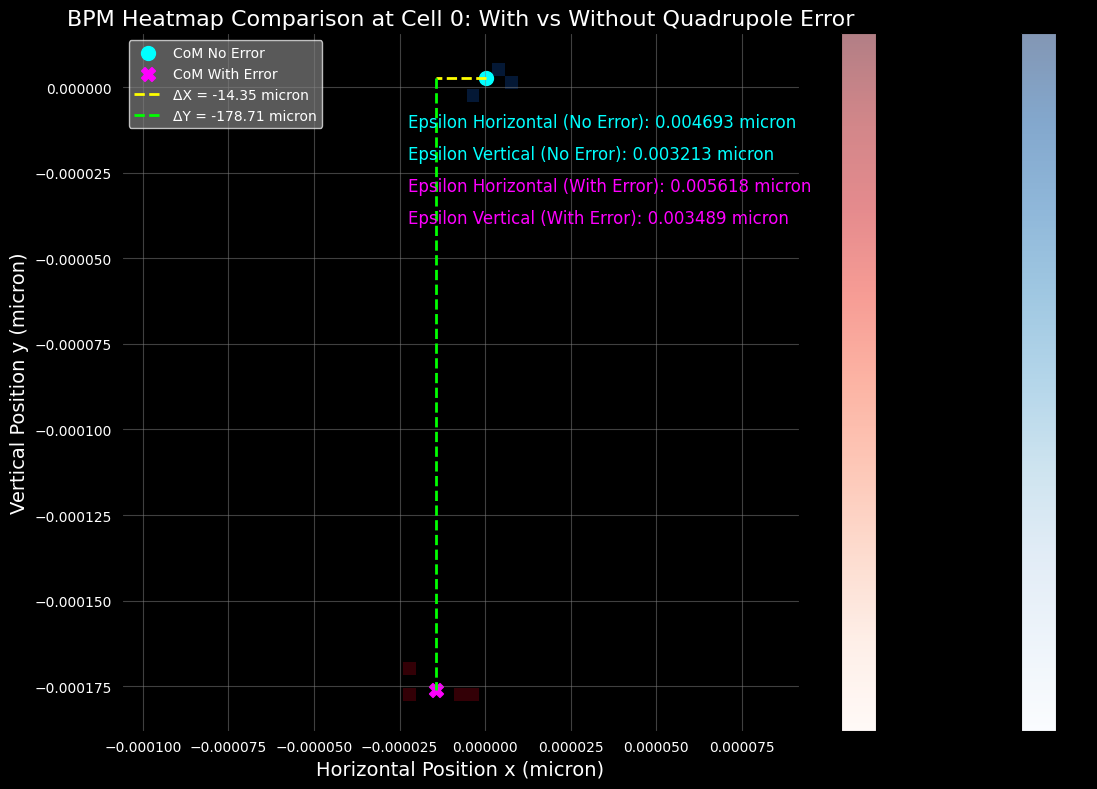

An unexpected error occurred in configuration 'Configuration 1': 'SynchrotronSimulator' object has no attribute 'plot_comparison'
Skipping this configuration.

Traceback (most recent call last):
  File "/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py", line 3435, in run_configurations
    simulator_no_error.plot_comparison(simulator_with_error, cell_idx=cell_idx, viz_start_idx=viz_end_idx - 100,
AttributeError: 'SynchrotronSimulator' object has no attribute 'plot_comparison'



In [20]:
runner = SimulationRunner(
    base_configurations=base_configurations,
    common_parameters=common_parameters
)

# Run all configurations
# initial_states = [[0.05, 0.001, 0.05, 0.001]] * common_parameters['num_particles']

initial_states = None

# initial_states = [[ 0.00000000e+00, -1.75842232e-05, -0.00000000e+00, -0.00000000e+00]]

runner.run_configurations(initial_states=initial_states)

# Example of accessing a specific simulator instance for further analysis
# For instance, accessing 'Configuration 1 - With Error'
config_key = 'Configuration 1 - With Error'
if config_key in runner.simulators_with_error:
    simulator = runner.simulators_with_error[config_key]
    # Perform additional analysis or plotting as needed
    # Example: simulator.plot_additional_metrics()
else:
    print(f"{config_key} not found in simulators_with_error.")



In [21]:
sim_no_error = runner.simulators_no_error['Configuration 1 - No Error']
sim_with_error = runner.simulators_with_error['Configuration 1 - With Error']

In [22]:
sim_no_error.bpm_readings['x'].shape

(500000, 5, 8)

In [31]:
sim_no_error.plot_phase_space_diagram(first_axis='x', second_axis='y', plot_all=True, start_idx=0, save_label='test_no_error', fontsize=18)

/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:2678: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.

KeyboardInterrupt



Error in callback <function flush_figures at 0x7fb993c63400> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [ ]:
sim_with_error.plot_phase_space_diagram(first_axis='x', second_axis='y', plot_all=True, start_idx=0 ,save_label='test_with_error', fontsize=18)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


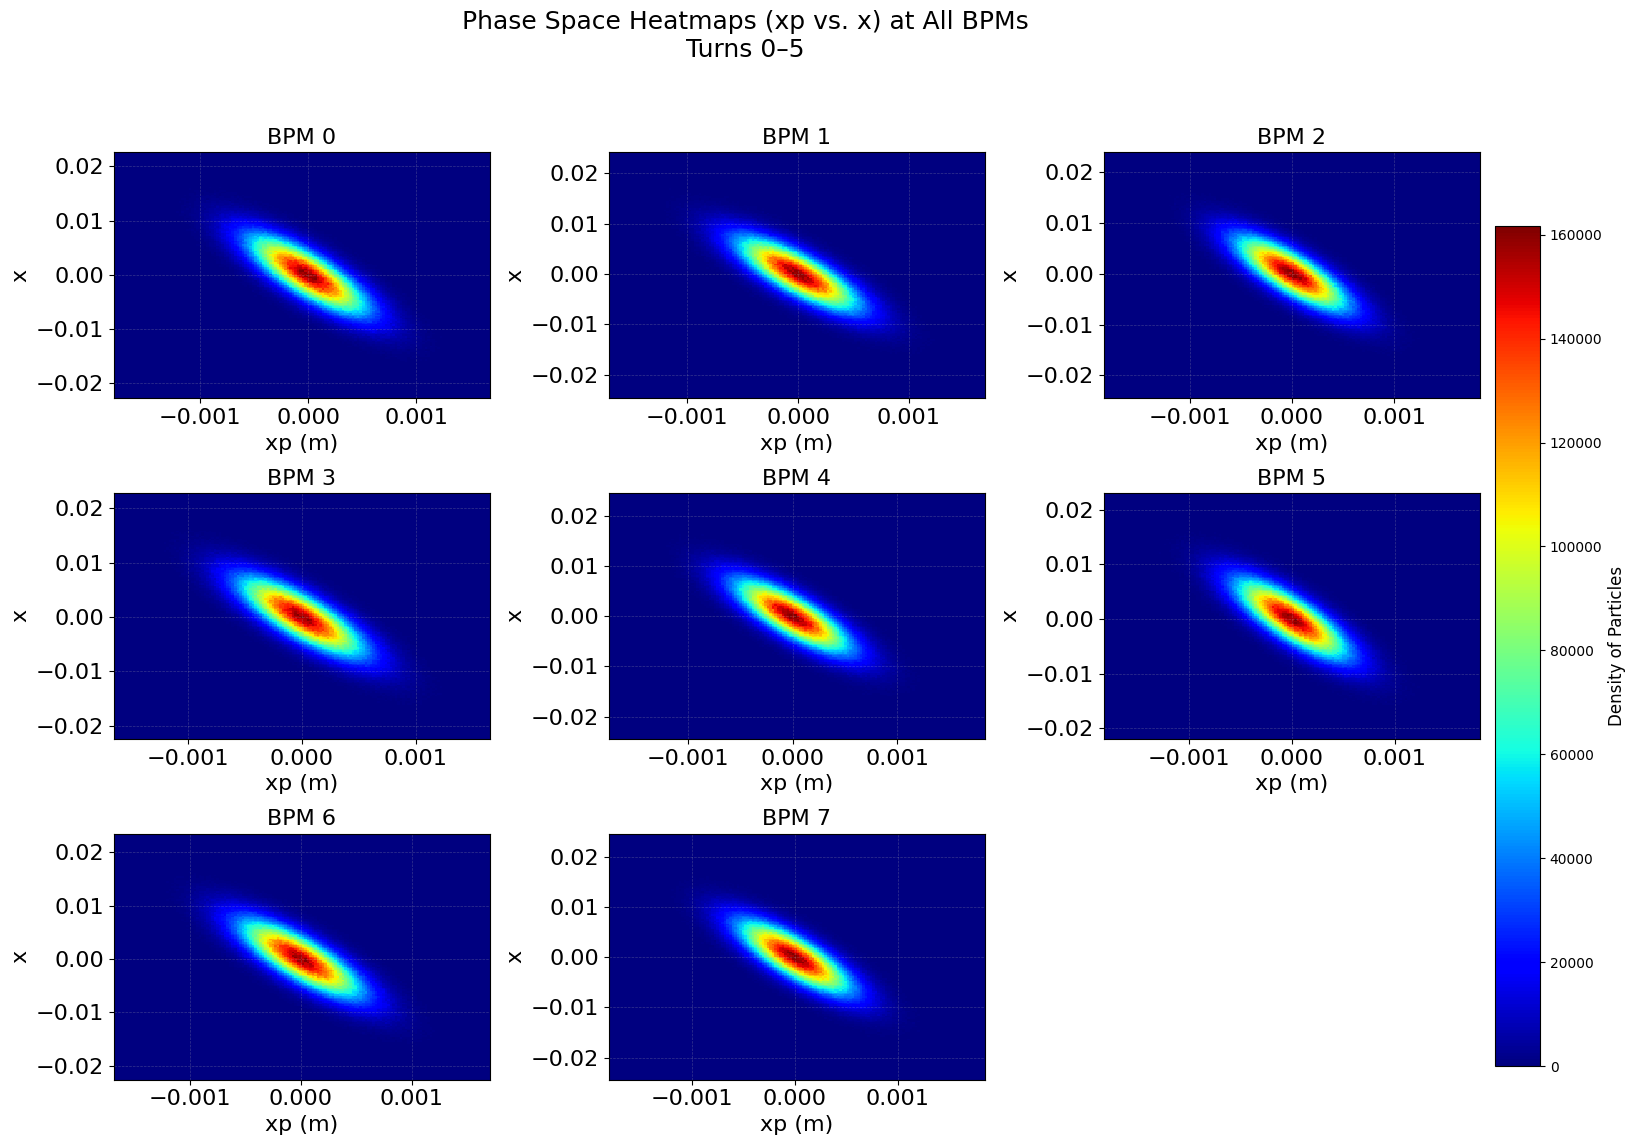

In [32]:
sim_no_error.plot_phase_space_diagram(first_axis='xp', second_axis='x', plot_all=True, start_idx=0, save_label='x_xp_test_no_error', fontsize=18)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


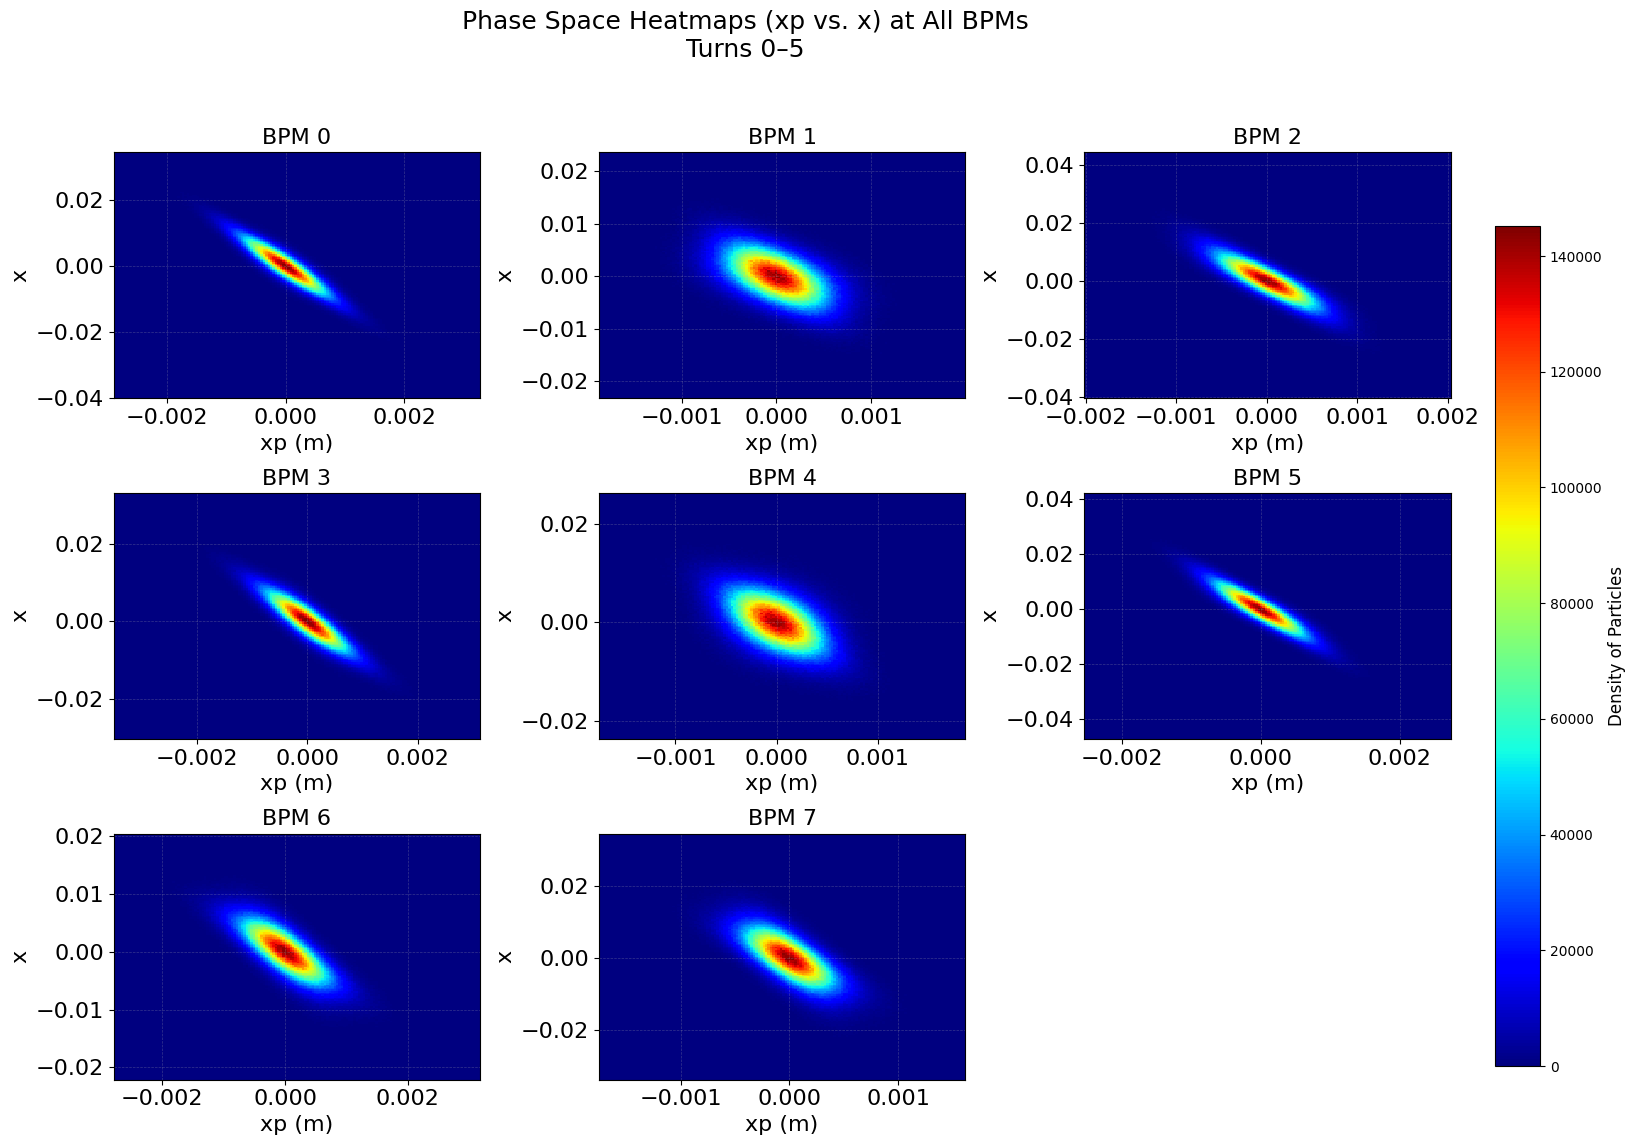

In [33]:
sim_with_error.plot_phase_space_diagram(first_axis='xp', second_axis='x', plot_all=True, start_idx=0 ,save_label='x_xp_test_with_error', fontsize=18)

In [ ]:
sim_no_error.plot_phase_space_diagram(first_axis='yp', second_axis='y', plot_all=True, start_idx=0, save_label='y_yp_test_no_error', fontsize=18)

In [ ]:
sim_with_error.plot_phase_space_diagram(first_axis='yp', second_axis='y', plot_all=True, start_idx=0 ,save_label='y_yp_test_with_error', fontsize=18)

In [45]:
sim_with_error.figs_save_dir

'figs'

In [46]:
sim_no_error.n_turns

5

In [47]:
4 * 4

16

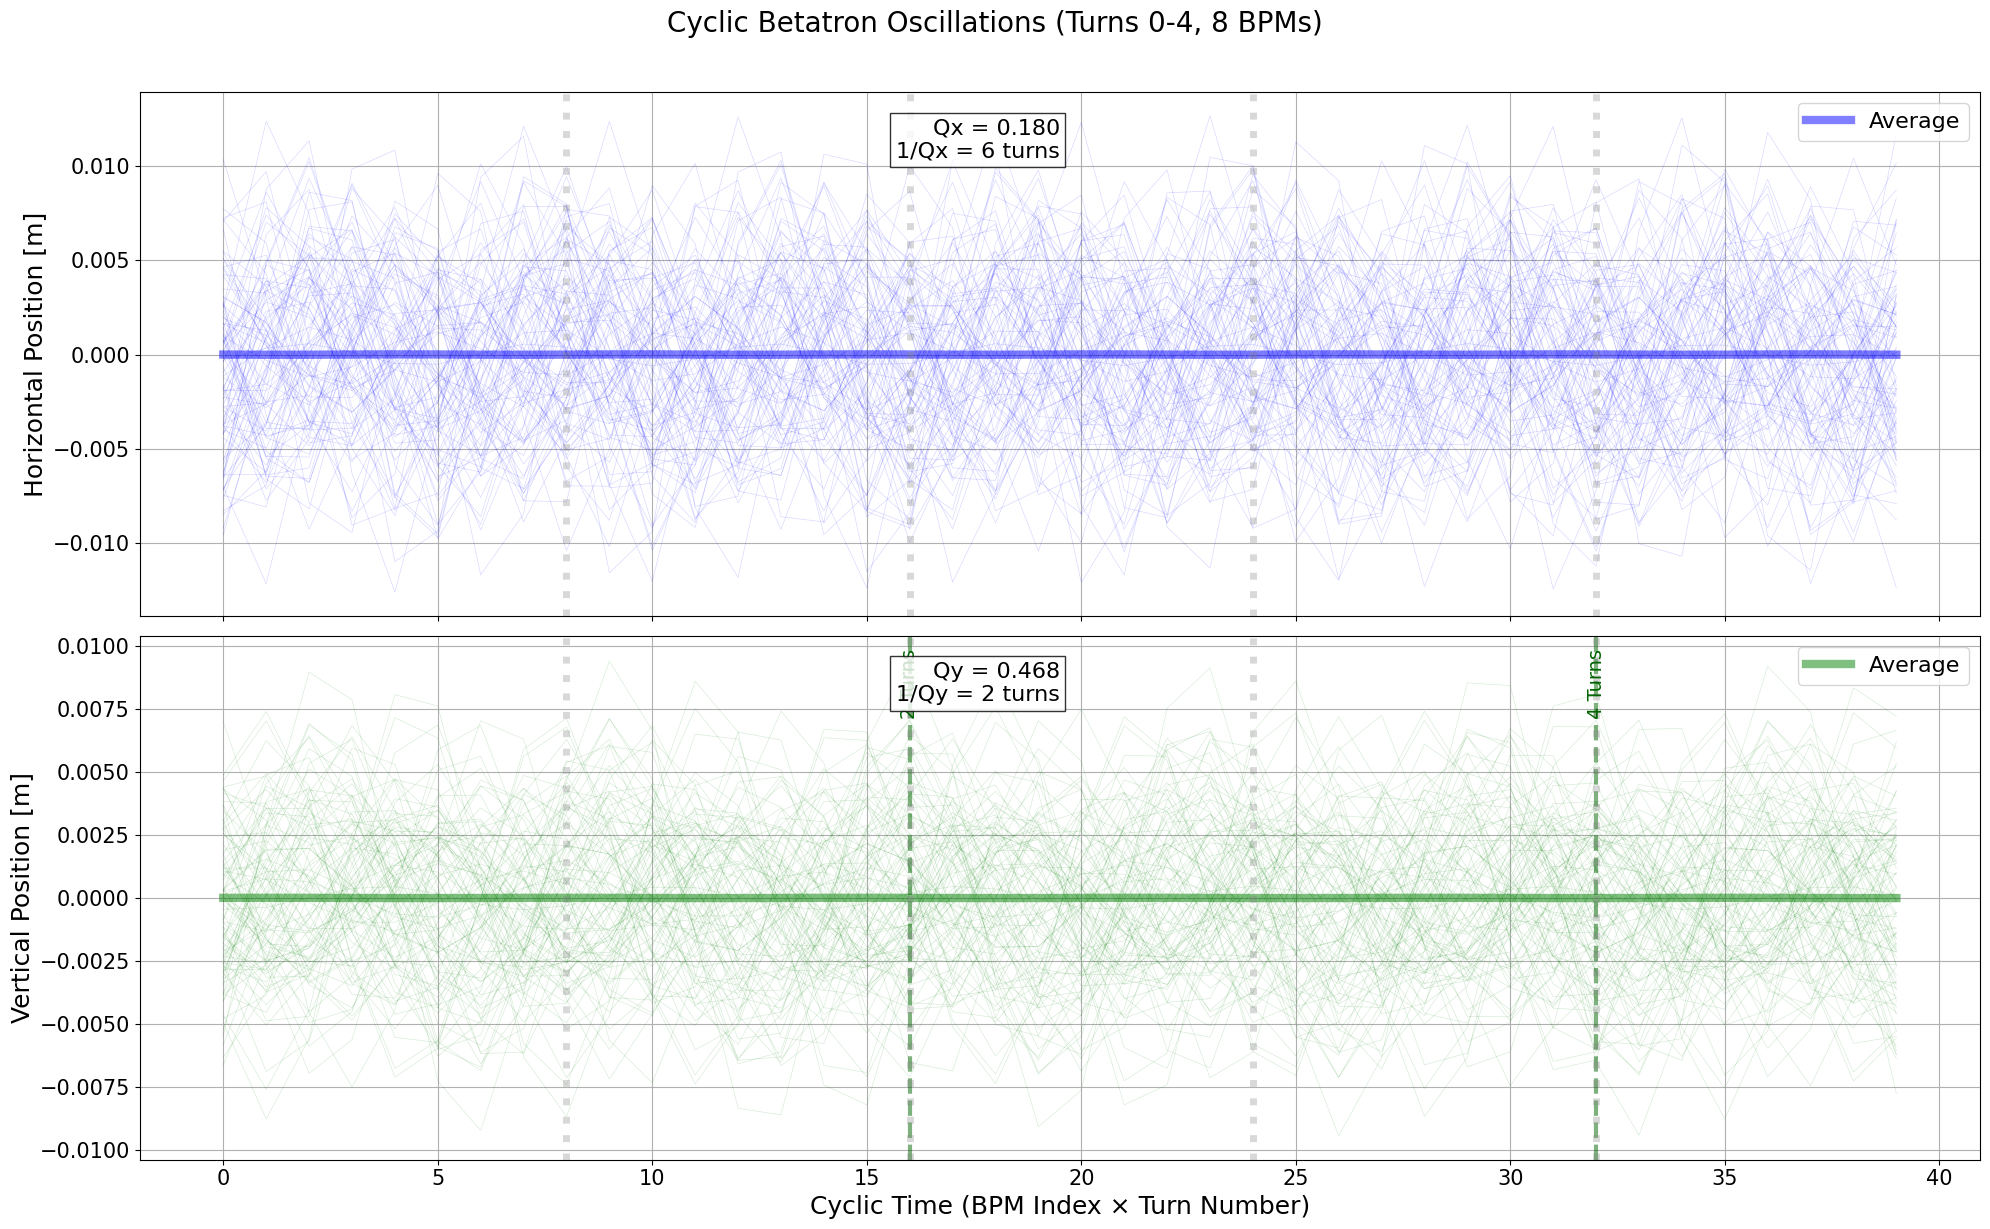

In [50]:
sim_no_error.plot_betatron_oscillations_TURN_FLATTEN(
    n_particles=100,
    start_turn=0, 
    end_turn=10,
    save_label='no_error',
)


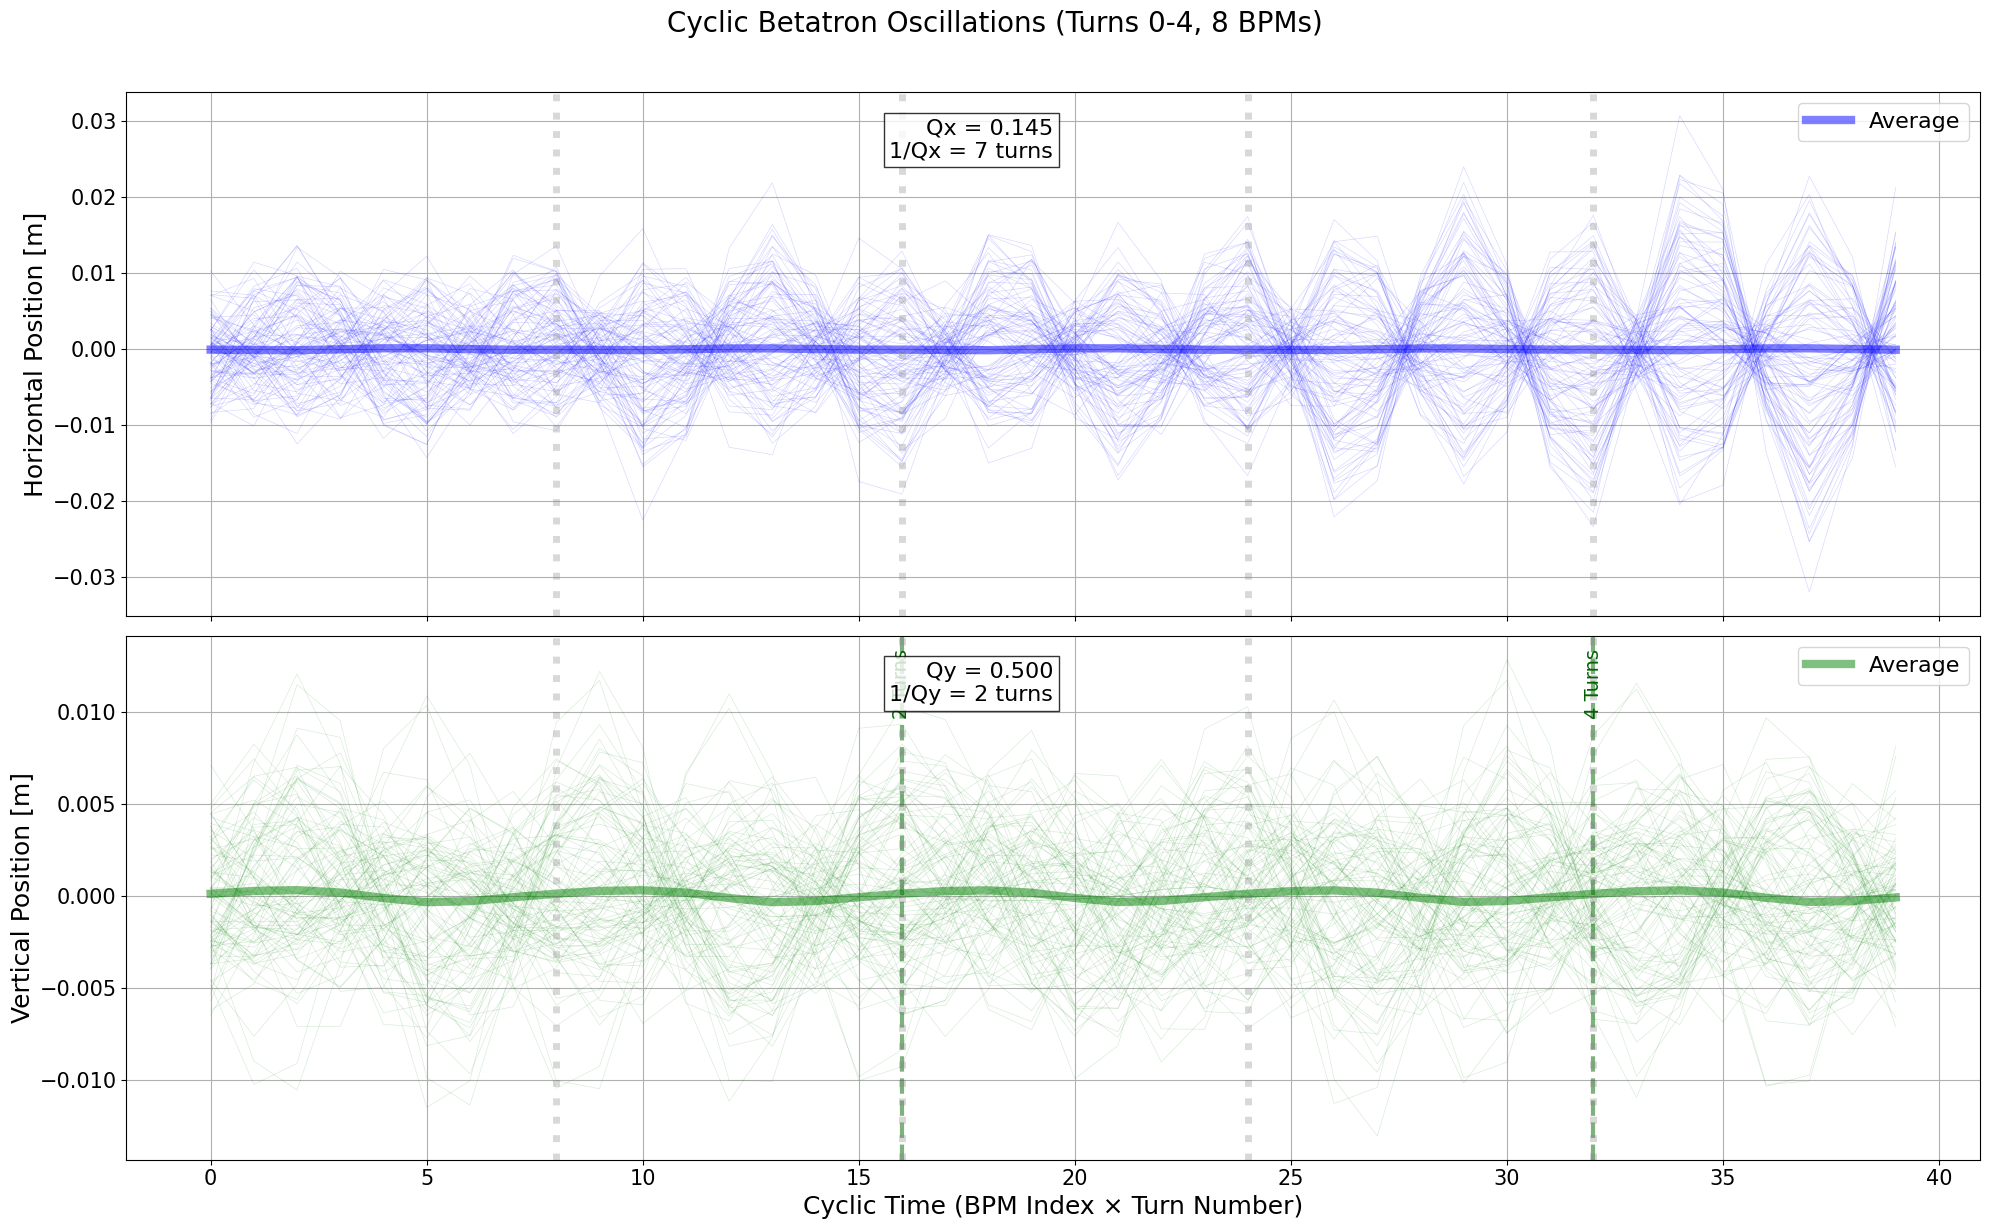

In [51]:
sim_with_error.plot_betatron_oscillations_TURN_FLATTEN(
    n_particles=100,
    start_turn=0, 
    end_turn=10,
    save_label='with_error',
)


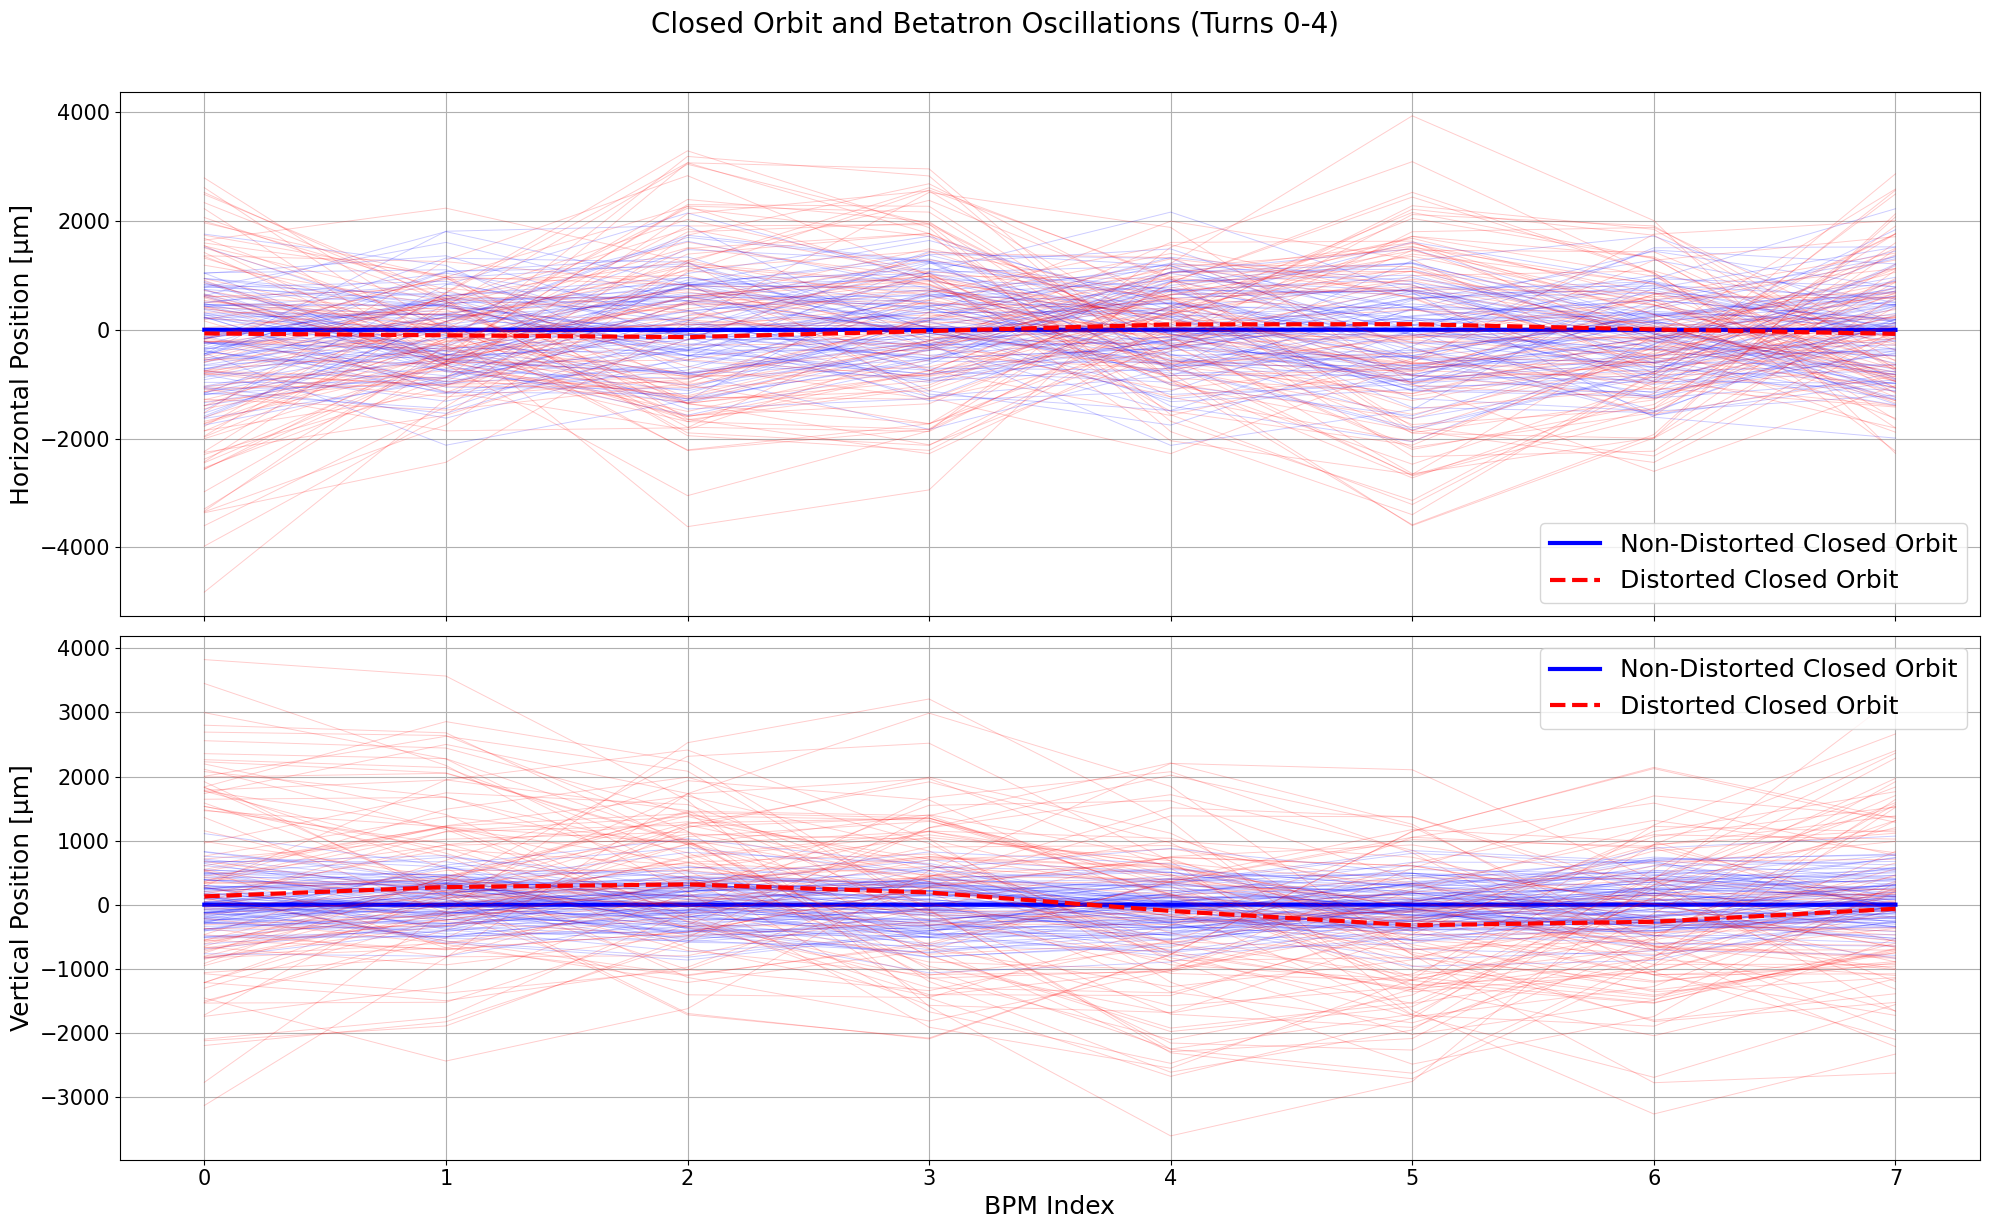

In [53]:
sim_no_error.plot_betatron_oscillations_BPM(
    sim_with_error,
    n_particles=100,
    start_turn=0, 
    end_turn=10,
    save_label='comparison',
)


In [21]:
-1.75842232e-05

-1.75842232e-05

In [22]:
0.5949649+0.80375168j

(0.5949649+0.80375168j)

In [23]:
 [[ 3.32244410e-01, -6.33731995e+00, -1.01349045e-17,  4.47729428e-17],
 [ 5.70374284e-02,  1.92188506e+00,  1.43910248e-17, -6.38588592e-17],
 [-3.12002922e-18,  4.13583235e-17,  7.37394901e-01, -3.85271430e+00],
 [ 5.41646199e-18, -7.27206950e-17,  4.37603267e-01, -9.30248316e-01]]

[[0.33224441, -6.33731995, -1.01349045e-17, 4.47729428e-17],
 [0.0570374284, 1.92188506, 1.43910248e-17, -6.38588592e-17],
 [-3.12002922e-18, 4.13583235e-17, 0.737394901, -3.8527143],
 [5.41646199e-18, -7.2720695e-17, 0.437603267, -0.930248316]]

In [ ]:
7.37394901e-01

In [ ]:
-1.75842232e-05

In [ ]:
particle_idx = 0
start_idx = 7800
end_idx = 8000


print("  Quadrupole Tilt Error 1: FODO Cell 3, Defocusing, Tilt Angle = np.pi/2 rad (90 degrees)")
sim_no_error.plot_particle_bpm_readings(particle_idx, start_idx, end_idx)
sim_with_error.plot_particle_bpm_readings(particle_idx, start_idx, end_idx)

In [ ]:
particle_idx = 0
start_idx = 7000
end_idx = 8000


print("  Quadrupole Tilt Error 1: FODO Cell 3, Defocusing, Tilt Angle = -0.5235987755982988 rad (30 degrees)")
sim_no_error.plot_particle_bpm_readings(particle_idx, start_idx, end_idx)
sim_with_error.plot_particle_bpm_readings(particle_idx, start_idx, end_idx)

In [ ]:
viz_end_idx = sim_no_error.n_turns
sim_no_error.plot_comparison(sim_with_error, cell_idx=0, viz_start_idx=viz_end_idx - 200,
                     viz_end_idx=viz_end_idx, save_label="sim_test", window_size=50, plot_all=True, extra_title="All BPMs")

In [ ]:
sim_no_error.plot_phase_space_diagram(first_axis='x', second_axis='y', cell_idx=4, plot_all=False)

In [ ]:
sim_no_error.plot_phase_space_diagram(first_axis='x', second_axis='xp', cell_idx=i, plot_all=True)

In [ ]:
sim_no_error.plot_phase_space_diagram(first_axis='y', second_axis='yp', cell_idx=i, plot_all=True)

In [ ]:
sim_with_error.plot_phase_space_diagram(first_axis='x', second_axis='xp', cell_idx=i, plot_all=True)

In [ ]:
sim_with_error.plot_phase_space_diagram(first_axis='y', second_axis='yp', cell_idx=i, plot_all=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


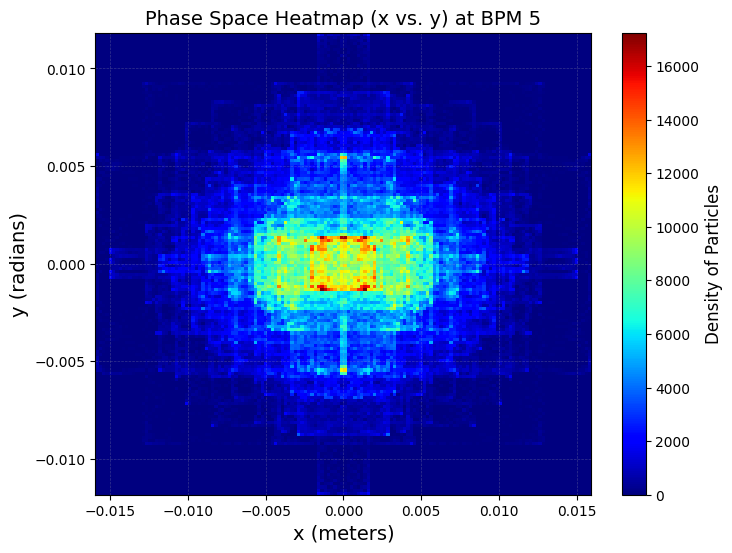

In [26]:
sim_no_error.plot_phase_space_diagram(first_axis='x', second_axis='y', cell_idx=5)

In [ ]:
sim_with_error.plot_phase_space_diagram(first_axis='x', second_axis='y', cell_idx=5)

In [ ]:
sim_with_error.plot_phase_space_diagram(first_axis='xp', second_axis='x', cell_idx=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


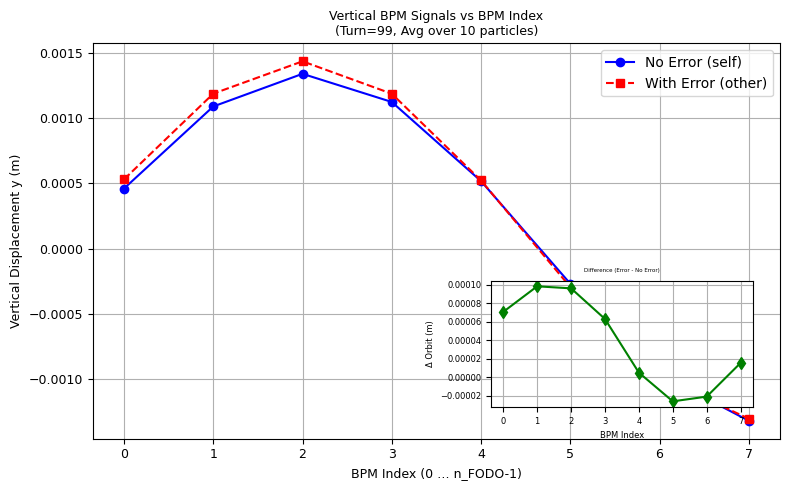

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Vertical BPM Signals vs BPM Index\n(Turn=99, Avg over 10 particles)'}, xlabel='BPM Index (0 … n_FODO-1)', ylabel='Vertical Displacement y (m)'>)

In [34]:
sim_no_error.compare_bpm_signal_vs_bpm_number(
    other_simulator=sim_with_error,
    turn=99,
    plane='vertical',
    average_over_particles=True,
    plot_difference=True
)


In [ ]:
cell_idx = 0
sim_no_error.plot_bpm_comparison_last_images(sim_no_error, sim_with_error, cell_idx=cell_idx, particles='all_mean')
viz_start_idx = sim_no_error.n_turns - 100
viz_end_idx = sim_no_error.n_turns
sim_no_error.plot_comparison(sim_with_error, cell_idx=cell_idx, viz_start_idx=viz_start_idx, viz_end_idx=viz_end_idx)

In [ ]:
cell_idx = 0
sim_no_error.plot_bpm_comparison_last_images(sim_no_error, sim_with_error, cell_idx=cell_idx, particles='all_mean')
viz_start_idx = sim_no_error.n_turns - 100
viz_end_idx = sim_no_error.n_turns
sim_no_error.plot_comparison(sim_with_error, cell_idx=cell_idx, viz_start_idx=viz_start_idx, viz_end_idx=viz_end_idx)

In [ ]:

total_elements_no_error = len(sim_no_error.M_lattice_4x4)
total_elements_with_error = len(sim_with_error.M_lattice_4x4)

total_elements_no_error, total_elements_with_error

In [ ]:
sim_no_error.M_lattice_4x4[12]

In [ ]:
sim_with_error.M_lattice_4x4[13]

In [ ]:
sim_no_error.n_turns

In [ ]:
sim_no_error.bpm_readings['x'].shape

In [ ]:
# sim_no_error.bpm_readings['x']

In [ ]:
ix = 0

In [ ]:
bpm_ix = 0

plt.plot(sim_no_error.bpm_readings['y'][:, 0, bpm_ix].flatten())
plt.plot(sim_no_error.bpm_readings['y'][:, ix, bpm_ix].flatten())
plt.show()
plt.plot(sim_no_error.bpm_readings['x'][:, 0, bpm_ix].flatten(), sim_no_error.bpm_readings['y'][:, 0, bpm_ix].flatten(), '.')
plt.plot(sim_no_error.bpm_readings['x'][:, ix, bpm_ix].flatten(), sim_no_error.bpm_readings['y'][:, ix, bpm_ix].flatten(), '.')
plt.show()
ix+=1

In [ ]:
xy_lim = 0.2
plot_xlim = (-xy_lim, xy_lim)
plot_ylim = (-xy_lim, xy_lim)

plot_xlim = None
plot_ylim = None

for i in range(sim_no_error.n_FODO):
    sim_with_error.plot_bpm_heatmaps(
        cell_idx=i, 
        simulation_label='No Error', 
        start_idx=0, 
        end_idx=10,
        plot_xlim=plot_xlim, 
        plot_ylim=plot_ylim)


In [ ]:
from IPython.display import clear_output


xy_lim = 0.1
plot_xlim = (-xy_lim, xy_lim)
plot_ylim = (-xy_lim, xy_lim)

plot_xlim = None
plot_ylim = None

cell_idx = 1
start_idx = 0
for i in range(2):
    sim_with_error.plot_bpm_heatmaps(
        cell_idx=cell_idx, 
        simulation_label='No Error', 
        start_idx=start_idx, 
        end_idx=start_idx+i+1,
        plot_xlim=plot_xlim, 
        plot_ylim=plot_ylim)
    
    clear_output(wait=True)


In [ ]:
sim_no_error.n_turns

In [ ]:
xy_lim = 0.1
plot_xlim = (-xy_lim, xy_lim)
plot_ylim = (-xy_lim, xy_lim)

plot_xlim = None
plot_ylim = None

for i in range(sim_no_error.n_FODO):
    sim_no_error.plot_bpm_heatmaps(
        cell_idx=i, 
        simulation_label='No Error', 
        start_idx=0, 
        end_idx=1500,
        plot_xlim=plot_xlim, 
        plot_ylim=plot_ylim)


In [ ]:
for i in range(sim_no_error.n_FODO):
    particle_idx_start = 0
    particle_idx_end = 10
    start_idx = 0
    end_idx = -1
    cell_idx = i
    

    x_data = sim_no_error.bpm_readings['x'][particle_idx_start:particle_idx_end, start_idx:end_idx, cell_idx]
    xp_data = sim_no_error.bpm_readings['xp'][particle_idx_start:particle_idx_end, start_idx:end_idx, cell_idx]
    
    # x - x'
    plt.figure(figsize=(8,6))
    plt.scatter(x_data, xp_data, alpha=0.7)
    plt.xlabel('x (meters)')
    plt.ylabel("x' (radians)")
    plt.title(f'Phase Space Diagram at BPM {cell_idx}')
    plt.grid(True)
    plt.show()

In [ ]:
particle_idx = 0
start_idx = 1900
end_idx = 2000

sim_no_error.plot_particle_bpm_readings(particle_idx, start_idx, end_idx)

In [ ]:
1 / sim_no_error.Qx

In [ ]:
sim_no_error.n_turns

In [ ]:
xy_lim = 0.005
plot_xlim = (-xy_lim, xy_lim)
plot_ylim = (-xy_lim, xy_lim)

# plot_xlim = None
# plot_ylim = None

sim_no_error.plot_all_bpm_heatmap(start_idx=0, end_idx=-1, plot_ylim=plot_ylim, plot_xlim=plot_xlim)

In [ ]:
help(sim_no_error.plot_all_bpm_heatmap)

In [ ]:
# xy_lim = 0.1
# plot_xlim = (-xy_lim, xy_lim)
# plot_ylim = (-xy_lim, xy_lim)

# # plot_xlim = None
# # plot_ylim = None

# for i in range(sim_with_error.n_FODO):
#     sim_with_error.plot_bpm_heatmaps(cell_idx=i, simulation_label='With Error', plot_xlim=plot_xlim, plot_ylim=plot_ylim)


In [ ]:
# sim_with_error.plot_average_positions()

In [ ]:
for i in range(sim_no_error.n_FODO):
    sim_no_error.plot_last_bpm_image(cell_idx=i)

In [ ]:
# args: plot_xlim=(15, 17), plot_ylim=(-10, -12)
plot_xlim = (-22, -18)
plot_ylim = (5, -5)

# plot_xlim = None
# plot_ylim = None

fig, ax = sim_no_error.plot_particle_trajectory(start_idx=0, end_idx=5, plot_xlim=plot_xlim, plot_ylim=plot_ylim)

In [ ]:
# plot_xlim = (-6, -7)
# plot_ylim = (-15, -10.5)

plot_xlim = None
plot_ylim = None

fig, ax = sim_no_error.plot_particle_trajectory(start_idx=1, end_idx=10, plot_xlim=plot_xlim, plot_ylim=plot_ylim)

### Generate Datasets

In [ ]:
# # Parameters for generate_data
# 'start_rev': 0,
# 'end_rev': 500,
# 'fodo_cell_indices': list(range(8)),  # Indices of BPMs to consider
# 'planes': ['x', 'y'],
# 'cell_idx': 0,
# 'max_revolutions': 100

In [ ]:
sim_no_error.bpm_readings['y'].shape

In [ ]:
simulation_dataset = SimulationDataset(
    bpm_readings_no_error=sim_no_error.bpm_readings,
    bpm_readings_with_error=sim_with_error.bpm_readings,
    bpm_positions=sim_no_error.bpm_positions,
    quadrupole_errors=sim_with_error.quad_errors,
    lattice_reference=sim_no_error.get_lattice_reference()
)

input_tensor, target_tensor = simulation_dataset.generate_data(
    1000, 1500, [7], ['x', 'y']
)

In [ ]:
input_tensor.shape

In [ ]:
input_tensor[0, :, 0, 0, np.newaxis].shape
# plot(input_tensor[0, :, 0, 0, np.newaxis])

In [ ]:
np.concatenate([running_average_numpy(input_tensor[0, :, 0, 0], 100)[..., np.newaxis], running_average_numpy(input_tensor[0, :, 0, 0], 100)[..., np.newaxis]], axis=-1).shape

In [ ]:
target_tensor

In [ ]:
def running_average_numpy(data, window_size):
    data = np.asarray(data)
    if window_size <= 0:
        raise ValueError("Window size must be positive.")
    if window_size > len(data):
        raise ValueError("Window size cannot be larger than the data length.")

    # Use 'valid' mode to ensure the window fits completely within the data
    window = np.ones(window_size) / window_size
    running_avg = np.convolve(data, window, mode='valid')
    return running_avg

In [ ]:
plot(sim_no_error.bpm_readings['x'][0, -10:, 0])
plot(sim_with_error.bpm_readings['x'][0, -10:, 0])


In [ ]:
cumu_y = sim_no_error.cumulative_average(input_tensor[0, :, 0, 1])
ravg_y = running_average_numpy(input_tensor[0, :, 0, 1], window_size=100)
plot(input_tensor[0, 0:, 0, 1])
plot(cumu_y[0:])
plot(ravg_y[0:])

show()

plot(ravg_y[-100:])
plot(cumu_y[-100:])
# plot(input_tensor[0, -5:, 0, 1])
legend(['ravg_y', 'cumu_y'])

In [ ]:
cumu_y = sim_no_error.cumulative_average(input_tensor[0, :, 0, 1])
ravg_y = running_average_numpy(input_tensor[0, :, 0, 1], window_size=1500)
plot(input_tensor[0, 1000:, 0, 1])
plot(cumu_y[1000:])
plot(ravg_y[1000:])

show()

plot(ravg_y[-100:])
plot(cumu_y[-100:])
# plot(input_tensor[0, -5:, 0, 1])
legend(['ravg_y', 'cumu_y'])

In [ ]:
plot(ravg_y[-100:])

In [ ]:
plot(cumu_y[-1900:])
plot(cumu_y[-1400:])

In [ ]:
ravg_y.shape

In [ ]:
plot(cumu_y[1000:])
# plot(ravg_y[1000:])

In [ ]:
plot(ravg_y[-100:])
plot(cumu_y[-100:])
# plot(input_tensor[0, -5:, 0, 1])
legend(['ravg_y', 'cumu_y'])

In [ ]:
# sim_with_error.plot_ring()

In [ ]:
sim_no_error.plot_comparison(sim_with_error, cell_idx=0)

In [ ]:
sim_no_error.plot_comparison(sim_with_error, cell_idx=0, viz_start_idx=0, viz_end_idx=1000)

In [ ]:
sim_no_error.bpm_readings['x'].shape

In [ ]:
self_y_cumu_avg_no_error = sim_no_error.cumulative_average(sim_no_error.overall_avg_y_positions)
other_y_cumu_avg_w_error = sim_no_error.cumulative_average(sim_with_error.overall_avg_y_positions)

In [ ]:
# def cumulative_average(arr, axis=-1):
#     if type(arr) == list:
#         arr = np.array(arr)
#     cumsum = np.cumsum(arr, axis=axis)
#     print(f"cumsum.shape={cumsum.shape}")
    
#     # Create a denominator array for cumulative averages
#     shape = np.ones(len(arr.shape), dtype=int)  # Create a shape of all ones
#     shape[axis] = arr.shape[axis]               # Set the correct dimension along the specified axis
#     denom = np.arange(1, arr.shape[axis] + 1).reshape(shape)  # Reshape to match the axis dimension

#     cumavg = cumsum / denom  # Broadcast division
#     return cumavg


In [ ]:
plot(self_y_cumu_avg_no_error[30:], 'b')
plot(other_y_cumu_avg_w_error[30:], 'g')
legend(['No Error', 'With Error'])

In [ ]:
plot(self_y_cumu_avg_no_error[7800:], 'b')
plot(other_y_cumu_avg_w_error[7800:], 'g')
legend(['No Error', 'With Error'])

In [ ]:
# plot(self_y_cumu_avg_no_error[800:])
# plot(other_y_cumu_avg_w_error[800:])

In [ ]:
sim_with_error.describe()

In [ ]:
sim_no_error.describe()

In [ ]:
runner.simulators_no_error.keys()

In [ ]:
runner.simulators_with_error.keys()

In [ ]:
sim = runner.simulators_no_error['Configuration 1 - No Error']

In [ ]:
sim.plot_average_positions()

In [ ]:
vertical_state = np.array(sim.particles_states_y)

In [ ]:
vertical_state.shape

In [ ]:
plot(vertical_state[:, 5000, 0])

In [ ]:
# window_size = 100
# plot(np.convolve(vertical_state[0, :, 0], np.ones(window_size)/window_size))


# Data for one particle
# time_series = vertical_state[0, :, 0]

# Data for all particles
time_series = np.mean(vertical_state[:, :, 0], axis=0)
running_avg = []
total_sum = 0
for i in range(len(time_series)):
    total_sum += time_series[i]
    avg = total_sum / (i + 1)
    running_avg.append(avg)

In [ ]:
plot(running_avg[7:])

In [ ]:
from pylab import *
import numpy as np

def random_normal_between(min_val, max_val, mean, std_dev, size=1):
    numbers = []
    while len(numbers) < size:
        sample = np.random.normal(mean, std_dev, size)
        sample = sample[(sample >= min_val) & (sample <= max_val)]
        numbers.extend(sample)
    return np.array(numbers[:size])

def new_random():
    # Example usage:
    min_val = -0.05
    max_val = 0.05
    mean = 0
    std_dev = 1
    size = 1000
    
    x0s = random_normal_between(min_val, max_val, mean, std_dev, size)
    xp0s = np.zeros(1000)
    y0s = random_normal_between(min_val, max_val, mean, std_dev, size)
    yp0s = np.zeros(1000)

    initial_states_normal = np.vstack([x0s, xp0s, y0s, yp0s])
    
    print(initial_states_normal.shape)
    hist(initial_states_normal[:, 2], bins=100)
    hist(initial_states_normal[:, 0], bins=100)
    show()
    plot(initial_states_normal[:, 0], initial_states_normal[:, 2], '.')
    show()
    

def bad_normal():
    initial_states = []
    for i in range(1000):
        x0 = np.random.normal(-0.05, 0.005)
        xp0 = 0
        y0 = np.random.normal(-0.05, 0.005)
        yp0 = 0
        initial_states.append([x0, xp0, y0, yp0])

    initial_states_normal = np.array(initial_states).transpose((1,0))
    print(initial_states_normal.shape)
    hist(initial_states_normal[2, :], bins=100)
    hist(initial_states_normal[0, :], bins=100)
    show()
    plot(initial_states_normal[0, :], initial_states_normal[2, :], '.')
    show()

def correct_normal():
    x0s = np.random.normal(loc=0.0, scale=0.05, size=1000)
    xp0s = np.zeros(1000)
    y0s = np.random.normal(loc=0.0, scale=0.05, size=1000)
    yp0s = np.zeros(1000)
    
    
    initial_states_normal = np.stack([x0s, xp0s, y0s, yp0s], axis=1)
    print(initial_states_normal.shape)
    hist(initial_states_normal[:, 2], bins=100)
    hist(initial_states_normal[:, 0], bins=100)
    show()
    plot(initial_states_normal[:, 0], initial_states_normal[:, 2], '.')
    show()

    return initial_states_normal

initial_states_normal = correct_normal()

# bad_normal()